In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchaudio
import numpy as np
import seaborn; seaborn.set_style("darkgrid")
from tqdm.notebook import tqdm
import itertools
import random
import os

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu" ; device

# Control panel:

In [1]:
# Hyper-parameters
batch_size = 4
learning_rate = 0.001
epochs = 1
dilation_depth = 9
bins = 16
channels = 64
blocks = 1

# Model:

In [3]:
class Wavenet(nn.Module):
    def __init__(self, quantization_bins, channels, dilation_depth, blocks):
        super(Wavenet, self).__init__()

        """ Part 1: Define model parameters """""
        self.C = channels
        self.kernel_size = 2
        self.bins = quantization_bins
        self.dilations = [2 ** i for i in range(dilation_depth)] * blocks

        """ Part 2: Define model layers """
        self.pre_process_conv = nn.Conv1d(in_channels=self.bins, out_channels=self.C, kernel_size=1)
        self.causal_layers = nn.ModuleList()

        for d in self.dilations:
            self.causal_layers.append(ResidalLayer(in_channels=self.C, out_channels=self.C, dilation=d, kernel_size=self.kernel_size))

        self.post_process_conv1 = nn.Conv1d(self.C, self.C, kernel_size=1)
        self.post_process_conv2 = nn.Conv1d(self.C, self.bins, kernel_size=1)

    def forward(self, x, gc):
        """ Function: Makes the forward pass/model prediction
            Input: Mu- and one-hot-encoded waveform. The shape of the input is (batch_size, quantization_bins, samples).
                   It is important that 'x' has at least the length of the models receptive field.
            Output: Distribution for prediction of next sample. Shape (batch_size, quantization_bins, what's left after
                    dilation, should be 1 at inference) """

        """ Part 1: Through pre-processing layer """
        x = self.pre_process_conv(x)

        """ Part 2: Through stack of dilated causal convolutions """
        skips, skip = [], None

        for layer in self.causal_layers:
            x, skip = layer(x, gc)

            # Save skip connection results
            skips.append(skip)

        """ Part 3: Post processes (-softmax) """
        # Add skip connections together 
        x = sum([s[:, :, -skip.size(2):] for s in skips])

        # Do the rest of the preprocessing 
        x = F.relu(x)
        x = self.post_process_conv1(x)  
        x = F.relu(x)
        x = self.post_process_conv2(x)  

        return x

In [4]:
class ResidalLayer(nn.Module):
    """ Class description: This class is a sub-model of a residual layer (see research paper)"""

    def __init__(self, in_channels:int, out_channels:int, kernel_size:int, dilation:int):
        super(ResidalLayer, self).__init__()

        """ Part 1: Define model parameters """
        self.dilation = dilation

        """ Part 2: Define model layers """
        # The original Wa original WaveNet paper used a single shared 1x1 conv for both filter (f) and gate (g).
        # Instead we use one for each here i.e. conv_f and conv_g.
        self.conv_f = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, dilation=dilation)
        self.conv_g = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, dilation=dilation)
        
        # Global conditioning matrix-vector product layer 
        self.gc_layer_f = nn.Linear(10, out_channels)
        self.gc_layer_g = nn.Linear(10, out_channels)
        
        # 1 shared 1x1 convolution
        self.conv_1x1 = nn.Conv1d(out_channels, out_channels, kernel_size=1)

    def forward(self, x, gc):
        # Convolutions 
        f_x = self.conv_f(x)
        g_x = self.conv_g(x)
        
        # Global conditioning matrix-vector product
        f_gc = self.gc_layer_f(gc).view(x.size(0),-1,1)
        g_gc = self.gc_layer_g(gc).view(x.size(0),-1,1)
        
        # Send through gate
        f = torch.tanh(f_x + f_gc)      
        g = torch.sigmoid(g_x + g_gc)   
        z = f * g                      
        
        # Save for skip connection
        skip = self.conv_1x1(z)             

        # Save residual as input to next layer residual layer
        residual = x[:, :, self.dilation:] + skip

        return residual, skip

# Helper functions:

In [5]:
def one_hot(input, bins):
    """ Function: Makes a one-hot-encoding
        :param input: tensor (batch_size, samples)
        :param bins: quantization_bins
        :return: tensor of shape (batch_size, samples, quantization_bins). """
    
    as_int64 = input.long()
    one_hotted = F.one_hot(as_int64, num_classes=bins)
    correct_dims = one_hotted.transpose(1,2)
    as_float32 = correct_dims.float()
    return as_float32

def get_gc(labels):
    return F.one_hot(labels, num_classes=10).to(device).float()

def mu(images):
    return (torch.round(images*255) / (255//(bins-1))).long()

# Create training and test set:

In [1]:
my_transform = transforms.Compose([transforms.ToTensor()])
PATH = "./"

dataset_train = datasets.MNIST(PATH, download=True, train=True, transform=my_transform)
dataset_test = datasets.MNIST(PATH, download=True, train=False, transform=my_transform)

train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(dataset_test, batch_size=batch_size)

NameError: name 'transforms' is not defined

# Training: 

In [9]:
# Define model 
model = Wavenet(bins, channels, dilation_depth, blocks)
model.to(device);

# Define optimizer and loss function
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Variables for storing loss (for later visualization)
losses = []
test_losses = []

# Training loop
for epoch in range(epochs):
    progress_bar = tqdm(train_dl, total=len(train_dl))
    for images, labels in train_dl:
        model.train()
        
        # Global embedding consitisting of one-hot encoded label (train_set_size x 10)
        gc = get_gc(labels)
        
        # Correctly format data for Wavenet and it's loss
        images = images.view(-1, 784).to(device)
        y_true = mu(images)
        x = one_hot(y_true, bins=bins)

        # Predictions and loss 
        y_preds = model(x, gc)   
        loss = criterion(y_preds[:, :, :-1], y_true[:, -y_preds.size(2)+1:])

        # Updates
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        progress_bar.set_postfix({"train_loss": loss.detach().cpu().item()})
        progress_bar.update()


  0%|          | 0/15000 [00:00<?, ?it/s]

# Plot loss:

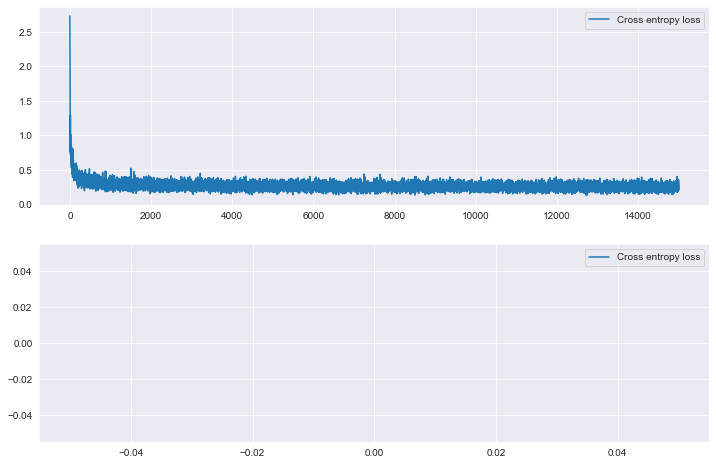

In [10]:
# Plots
_, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

ax1.plot(losses, label="Cross entropy loss")
ax1.legend()
ax2.plot(test_losses, label="Cross entropy loss")

ax2.legend()
plt.show()

# Generation:

In [2]:
def generate(seed: torch.tensor, label, amount: int, model, bins: int):
    """ Function: Inefficinet - but intutitive - implemenetation of sample generation
    :param seed: start the generation process, must be at least the size of the model's receptive field. Shape (1, samples)
    :param amount: number of samples to generate
    :return: list with [seed + generated_samples]
    """

    model.eval()
    temp = seed[0].tolist()
    next_point = -sum(model.dilations) - 1
    for n in range(amount):
        input = torch.tensor(temp[next_point:]).long().to(device)
        input = one_hot(input.unsqueeze(0), bins)
        predictions = model(input, get_gc(label))
        predictions = torch.softmax(predictions, dim=1)
        max_index = torch.multinomial(predictions[0, :, 0], 1).squeeze()
        temp.append(max_index.item())
    return temp

NameError: name 'torch' is not defined

# Plot:

In [ ]:
def show_images(nrow=2, ncol=2, random_seed=False, include_seed=False):
    _, axs = plt.subplots( nrow, ncol, figsize=(10,10) )
    coordinates = list(itertools.product([i for i in range(nrow)], [i for i in range(ncol)]))
    for i in range(nrow*ncol):
        idx = random.randint(0, len(dataset_train))
        if random_seed: seed = torch.rand(2**dilation_depth)
        else: seed = dataset_train[idx][0].view(28**2).to(device)[:2**dilation_depth]
        generate_length = 28**2  if not include_seed else 28**2-seed.shape[0] 
        seed = mu(seed).view(1,-1).to(device)
        label = torch.tensor([dataset_train[idx][1]])
        
        gen = generate(seed=seed, label=label, amount=generate_length , model=model, bins=bins)
        row, col = coordinates[i]
        
        gen = torch.tensor(gen) * (255//(bins-1))
        if include_seed:
            cut_off_row = (2**dilation_depth)//28
            gen = gen.view(28,28)
            gen[cut_off_row][:] = torch.tensor([128 for i in range(28)])
            gen.numpy()
        else:
            gen = gen[-28**2:].view(28,28).numpy()
        
        
        axs[row, col].imshow(gen, cmap="gray")
        axs[row, col].axis("off")
        axs[row, col].set_title(str(label.item()))
    
    plt.savefig("global.pdf", dpi = 180, bbox_inches = 'tight')
    plt.show()

show_images(ncol=4, nrow=4, random_seed=False, include_seed=True)